In [1]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools as it
import os
import networkx as nx
import scipy.optimize as opt
import warnings
warnings.filterwarnings('ignore')

In [2]:
###Using Gini, lorenz curve to describe temproral inequality
###different states corresponding
###different speicalities

In [3]:
state_dict={'Alabama':'AL','Alaska':'AK','Arkansas':'AR','Arizona':'AZ','California':'CA','Colorado':'CO',
           'Connecticut':'CT','Delaware':'DE','Florida':'FL','Georgia':'GA',
           'Hawai':'HI','Idaho':"ID",'Illinois':'IL','Indiana':'IN','Iowa':'IA','Kansas':'KS','Kentucky':'KY',
           'Louisiana':'LA','Maine':'ME','Marryland':'MD','Massachusetts':'MA','Michigan':'MI','Minnesota':'MN',
           'Mississippi':'MS','Missouri':'MO','Montana':'MT','Nebraska':'NE','Nevada':'NV','New hampshire':'NH','New jersey':'NJ',
           'New mexico':'NM','New york':'NY','North carolina':'NC','North dakota':'ND','Ohio':'OH','Oklahoma':'OK',
           'Oregon':'OR','Pennsylvania':'PA','Rhode island':'RI','South carolina':'SC','South dakota':'SD',
           'Tennessee':'TN','Texas':'TX','Utah':'UT','Vermont':'VT','Virgina':'VA','Washington':'WA',
            'West virgina':'WV','Wisconsin':'WI','Wyoming':'WY'}

In [4]:


states=['AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'IA', 'ID',
       'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO',
       'MS', 'MT', 'NC', 'NE', 'NH', 'NJ', 'NV', 'NY', 'OH', 'OK', 'OR',
       'PA', 'SC', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WV', 'WY']

dates = [range(2020, 2023), range(1, 13)]
races = ['White', 'Hispanic', 'Black', 'Asian']

incomes=['<= 10k','10k - 50k','50k - 100k','100k - 200k','>= 200k']

educations=['Less than high-school grudate','High-school grudate','Bachelor','Higher degree']

travel_times=['<=10 mins','10 mins - 19 mins','20 mins - 29 mins','30 mins - 44 mins','45 mins - 59 mins','>=60 mins']

specialities=['All','Family Practice', 'Emergency Medicine', 'Anesthesiology',
       'Cardiology', 'Obstetrics & Gynaecology']

specialities=['All', 'Emergency Medicine', 'Anesthesiology','Cardiology']

In [5]:
path_data='/Volumes/One Touch/Healthjump_dataset/Processed_data/'

In [6]:
color_list=['#fdb462','#8dd3c7','#fb8072', '#80b1d3','#bebada','#fdb462','#b3de69','#737373']
#,#fb8072

In [7]:
def set_fig_style(ax1, xlabel,ylabel,ratio):
    labelfont  = 14*ratio
    tickfont   = 14*ratio
    #tickfont   = 10*ratio
    legendfont = 14*ratio
    ax1.tick_params(axis='both', which='both', direction="in", labelsize=tickfont, pad=8 )
    for tick in ax1.xaxis.get_major_ticks(): tick.label.set_fontsize(tickfont)
    for tick in ax1.yaxis.get_major_ticks(): tick.label.set_fontsize(tickfont)

    ax1.set_xlabel(xlabel, fontsize=labelfont, labelpad=labelfont )
    ax1.set_ylabel(ylabel,fontsize=labelfont, labelpad=labelfont )
    #ax1.legend(loc='upper right', fontsize=legendfont, frameon=False)

    #ax1.spines.right.set_visible(False)
    #ax1.spines.top.set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

# Section 1.Compute gini

In [9]:
#https://www.cdc.gov/library/researchguides/health_disparity_measure.html

def gini_compute(data):
    
    data['rate']=data['count']/data['state_pop']  #patient_id   #state_pop
    
    data=data.sort_values(by=['rate'],ascending=True)
    
    Y_lorenz = list(data['count'].cumsum() / data['count'].sum())
    
    X_lorenz=list(data['state_pop'].cumsum() / data['state_pop'].sum())
    
    
    gini=Y_lorenz[0]*X_lorenz[0]
    
    for i in np.arange(1,len(X_lorenz)):
         gini+=(Y_lorenz[i]+Y_lorenz[i-1])*(X_lorenz[i]-X_lorenz[i-1])
    gini=1-gini
    
    if gini<0:
        #print(data[['rate','count','state_pop']])
        print(gini)
        print(X_lorenz)
        print(Y_lorenz)
    
    return gini


In [10]:
case='race_ethnicity'
case='age'
case='income'
case='education'
#case='travel_time'

if case=='race_ethnicity':
    state_demo=pd.read_csv('dataset/state_race.csv')
    demo=['White', 'Hispanic', 'Black', 'Asian']
    
if case=='age':
    state_demo=pd.read_csv('dataset/state_age_level.csv')
    demo=['children','young','middle','old']

if case=='income':
    state_demo=pd.read_csv('dataset/state_income_level.csv')
    demo=['<= 10k','10k - 50k','50k - 100k','100k - 200k','>= 200k']
    demo_list=incomes
    df_zip_code_demo=pd.read_csv('dataset/zipcode_income_level.csv')
    
if case=='education':
    state_demo=pd.read_csv('dataset/state_education_level.csv')
    demo=['Less than high-school grudate','High-school grudate','Bachelor','Higher degree']
    demo_list=educations
    df_zip_code_demo=pd.read_csv('dataset/zipcode_education_level.csv')
    
if case=='travel_time':
    state_demo=pd.read_csv('dataset/state_travel_time.csv')
    demo=['<=10 mins','10 mins - 19 mins','20 mins - 29 mins','30 mins - 44 mins','45 mins - 59 mins','>=60 mins']
    demo_list=travel_times
    df_zip_code_demo=pd.read_csv('dataset/zipcode_travel_time.csv')
    

ouput_data=[]
ouput_gini=[]
    
for state in states:
    print('===compute for state===  ',state)
    
    df=state_demo[state_demo['State_code']==state]
    state_demo_dict=dict(zip(df.columns,df.iloc[0].values))
    all_data = pd.read_pickle(path_data+state+'_nested_df.pkl')

    yearly_data=[]
    for year in range(2017,2023):
        df_data=all_data.at[state, year]
        df_data['year']=[year]*len(df_data)
        df_data['month']=list(map(lambda x: int(str(x)[4:6])+(year-2019)*12, df_data['date']))
        df_data['season']=(df_data['month']-1)/3+1
        
        #print(df_data.columns)
        for specialty in specialities:
            if specialty=='All':
                df_temp=df_data
            else:
                df_temp=df_data[df_data['speciality']==specialty]
            
            #print(state,year, specialty,len(df_temp))
            
            if case=='age' or case=='race_ethnicity':
                df_temp=df_temp[df_temp[case].isin(demo)]
                
                df_temp['count']=[1]*len(df_temp)
                df_temp=df_temp.groupby(['state','year',case,'month']).agg({'count': 'sum', 'patient_id': 'nunique'}).reset_index()
                
                #print(df_temp)
                ###accumulate 3month
                df_temp['state_pop']=list(map(lambda x: state_demo_dict[x], df_temp[case]))
                df_temp['specialty']=[specialty]*len(df_temp)
            
            if case=='income' or case=='education' or case=='travel_time':
                df_temp['count']=[1]*len(df_temp)
                df_temp=df_temp.groupby(['state','year','zip_code','month']).agg({'count': 'sum', 'patient_id': 'nunique'}).reset_index()
                df_temp=df_temp.merge(df_zip_code_demo,on=['zip_code'],how='left')
                #print(df_temp)
                
                ouput_temp=[]
                for col in demo_list:
                    for month, df_temp_temp in df_temp.groupby(['month']):
                        df_temp_temp['count']=df_temp_temp[col]*df_temp_temp['count']
                        df_temp_temp['patient_id']=df_temp_temp[col]*df_temp_temp['patient_id']
                        
                        ouput_temp.append([state,year,col,month,df_temp_temp['count'].sum(),df_temp_temp['patient_id'].sum()])
                
                if len(ouput_temp)>0:
                    df_temp=pd.DataFrame(np.mat(ouput_temp),columns=['state','year',case,'month','count','patient_id'])
                    df_temp['count']=df_temp['count'].astype(float)
                    df_temp['state_pop']=list(map(lambda x: state_demo_dict[x], df_temp[case]))
                    df_temp['specialty']=[specialty]*len(df_temp)
    
            #####compute gini
            if len(df_temp)>0:
                
                df_gini=pd.DataFrame()
                df_gini['gini']=[gini_compute(data_temp) for month,data_temp in df_temp.groupby(['month'])]
                df_gini['month']=[month for month,data_temp in df_temp.groupby(['month'])]
                df_gini['year']=[year]*len(df_gini)
                df_gini['state']=[state]*len(df_gini)
                df_gini['specialty']=[specialty]*len(df_gini)

                #print(state,year,df_gini['gini'].mean())
                ouput_data.append(df_temp)
                ouput_gini.append(df_gini)
    
ouput_data=pd.concat(ouput_data)
ouput_gini=pd.concat(ouput_gini)
    
ouput_data.to_csv('results/'+case+'/all_state_data.csv')
ouput_gini.to_csv('results/'+case+'/all_state_gini.csv')

===compute for state===   AL


FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/One Touch/Healthjump_dataset/Processed_data/AL_nested_df.pkl'

In [11]:

ouput_data[ouput_data['month']==1]

,state,year,race_ethnicity,month,count,patient_id,state_pop,specialty
0,AL,2019,Asian,1,579.0,253,75918.0,All
12,AL,2019,Black,1,17120.0,7357,1288159.0,All
24,AL,2019,Hispanic,1,2368.0,1514,264047.0,All
36,AL,2019,White,1,63226.0,32740,3171351.0,All
0,AL,2019,Asian,1,4.0,3,75918.0,Family Practice
...,...,...,...,...,...,...,...,...
0,WY,2019,Asian,1,2.0,1,5037.0,Anesthesiology
7,WY,2019,Hispanic,1,2.0,1,59046.0,Anesthesiology
18,WY,2019,White,1,109.0,55,469664.0,Anesthesiology
0,WY,2019,White,1,1.0,1,469664.0,Cardiology


## Section 2. Temporal inequality across state

In [12]:
def moving_average(list_input,window):
    list_output=list(map(lambda i:np.mean(list_input[i:i+window]) if i<=window  else np.mean(list_input[i-window:i]), np.arange(len(list_input))  ))
    return list_output

In [37]:
def temporal_curve_plot(data,state,case,path_fig):
    
    data=data.sort_values(by=['month'])
    
    
    
    if case!='gini' and case!='compare_gini':
        fig, ax = plt.subplots(1, 1, figsize=(5, 3))
   
        ax.axvspan(13, 49,alpha=0.05, color='grey')
        
        
        i=0
        for case_temp,df_temp in data.groupby(case):
            
            df_temp=df_temp.groupby(['month'])['count_normalized'].agg(['mean', 'std','count']).reset_index()   
            df_temp['ci'] = 1.96 * df_temp['std'] / np.sqrt(df_temp['count'])
            df_temp['ci_lower'] = df_temp['mean'] - df_temp['ci']
            df_temp['ci_upper'] = df_temp['mean'] + df_temp['ci']

            
            ax.plot(df_temp['month'].tolist(), df_temp['mean'].tolist(),color=color_list[i],label=case_temp,linewidth=3)
            ax.fill_between(df_temp['month'].tolist(), df_temp['ci_lower'].tolist(), df_temp['ci_upper'].tolist(), color=color_list[i], alpha=.1)
            
            i+=1
        
        set_fig_style(ax,'',"Accumulated average \n patient visit loss (Fraction) ",1)
        
        '''
        df_temp=data.groupby(['month'])['count_normalized'].agg(['mean', 'std','count']).reset_index()   
            
        print(df_temp)
        df_temp['ci'] = 1.96 * df_temp['std'] / np.sqrt(df_temp['count'])
        df_temp['ci_lower'] = df_temp['mean'] - df_temp['ci']
        df_temp['ci_upper'] = df_temp['mean'] + df_temp['ci']
        

        ax.plot(df_temp['month'], df_temp['mean'],color=color_list[2],linewidth=4)
        ax.fill_between(df_temp['month'], df_temp['ci_lower'], df_temp['ci_upper'], color=color_list[2], alpha=.1)
       
        set_fig_style(ax,'',"Patient visit loss (Fraction) ",1)
        '''
        ax.axhline(y = 0, color = 'grey', linestyle = '-',linewidth=1) 

        
        ax.set_ylim(-0.5,0.2)
        ax.legend(frameon=False,loc=3)

    if case=='gini':
        fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))
   
        ax.axvspan(13, 49,alpha=0.05, color='grey')
    
        df_temp=data
        df_temp=df_temp.groupby(['month'])['gini'].agg(['mean', 'std','count']).reset_index()   

        df_temp['ci'] = 1.96 * df_temp['std'] / np.sqrt(df_temp['count'])
        df_temp['ci_lower'] = df_temp['mean'] - df_temp['ci']
        df_temp['ci_upper'] = df_temp['mean'] + df_temp['ci']
        
        if df_temp['mean'].mean()>0:
            color=color_list[3]
        else:
            color=color_list[2]
        #print(df_temp['mean'].mean())
        ax.plot(df_temp['month'], df_temp['mean'],color=color,linewidth=4)
        
        ax.fill_between(df_temp['month'], [0]*len(df_temp), df_temp['mean'], color=color, alpha=.5)
        
        ax.axhline(y=0, color = 'grey', linestyle = '-',linewidth=1) 
        
        set_fig_style(ax,'','Health inequality \n change (Fraction)',1)
        
        ax.set_ylim(-0.22,0.22)
        ax.legend(frameon=False,loc=3)
        
    
    
    
    ax.set_xticks([1,13,25,37,49])
    ax.set_xticklabels(['Jan-19','Jan-20','Jan-21','Jan-22','Jan-23'],fontsize=14)

    plt.tight_layout()
    
    plt.savefig(path_fig, dpi = 600)

In [39]:
ouput_data

,Unnamed: 0,state,year,education,month,count,patient_id,state_pop,specialty
384,0,AL,2019,Less than high-school grudate,1,18853.454688,9463.242385,417675,All
385,1,AL,2019,Less than high-school grudate,2,20021.668265,9175.118230,417675,All
386,2,AL,2019,Less than high-school grudate,3,22278.260237,9412.812326,417675,All
387,3,AL,2019,Less than high-school grudate,4,21294.272558,10195.318342,417675,All
388,4,AL,2019,Less than high-school grudate,5,20219.783843,9840.651745,417675,All
...,...,...,...,...,...,...,...,...,...
48615,43,WY,2022,Higher degree,44,1.426568,0.570627,38586,Cardiology
48616,44,WY,2022,Higher degree,45,0.757293,0.614636,38586,Cardiology
48617,45,WY,2022,Higher degree,46,0.142657,0.142657,38586,Cardiology
48618,46,WY,2022,Higher degree,47,2.361447,0.856071,38586,Cardiology


age ====current case====
All
All 172
Emergency Medicine
Emergency Medicine 172
Anesthesiology
Anesthesiology 172
Cardiology
Cardiology 168


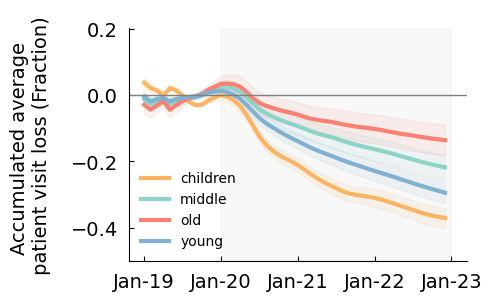

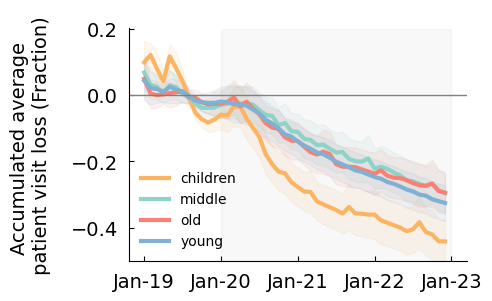

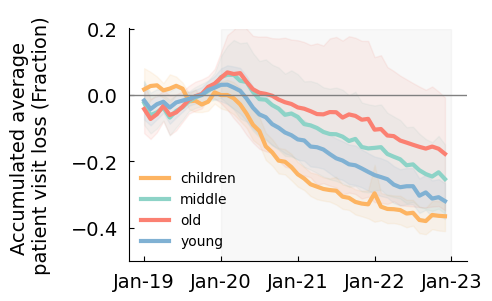

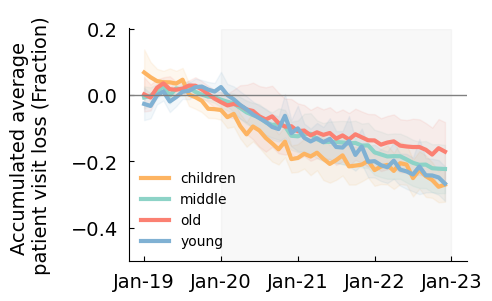

In [47]:

case='age'
#case='race_ethnicity'
#case='income'
#case='education'
print(case,'====current case====')


each_state_vis=False

ouput_data=pd.read_csv('results/'+case+'/all_state_data.csv')
ouput_data=ouput_data[ouput_data['year']>=2019]


#####realtive to pre-pandmic
for specialty in specialities:
    print(specialty)
    ouput_relative_data=[]
    
    ouput_data_temp=ouput_data[ouput_data['specialty']==specialty]
    count=0
    for state, df in ouput_data_temp.groupby(['state']):
        ouput_relative_state=[]
        for race,df_temp in df.groupby(case):
            if df_temp['count'].mean()>1:
                df_temp['count_normalized']=np.cumsum(df_temp['count'])/np.cumsum(df_temp['state_pop']) ##accumulated
                #df_temp['count_normalized']=df_temp['count']

                norm=df_temp[df_temp['month']<=13]['count_normalized'].mean()

                df_temp['count_normalized']=df_temp['count_normalized']/norm-1

                df_temp['count_normalized']=moving_average(df_temp['count_normalized'],3)
    
                #print(df_temp)
                ouput_relative_data.append(df_temp)
                ouput_relative_state.append(df_temp)
                count+=1
            #else:
               #print(state,race, df_temp['count'].mean())
                #print(df_temp['count'])
        
        if specialty=='All' and each_state_vis==True:
            
            ouput_relative_state=pd.concat(ouput_relative_state)
            temporal_curve_plot(ouput_relative_state,state,case,'results/'+case+'/state/temporal_'+specialty+'_'+state+'.png')
        
    ouput_relative_data=pd.concat(ouput_relative_data)   
    
    print(specialty,count)
    temporal_curve_plot(ouput_relative_data,state,case,'results/'+case+'/temporal_'+specialty+'.png')



income ====current case====


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


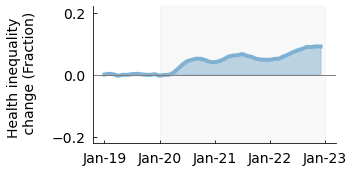

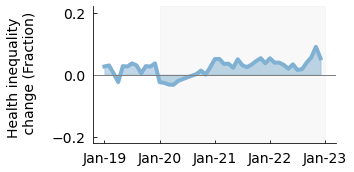

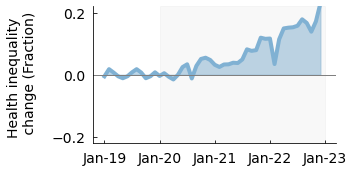

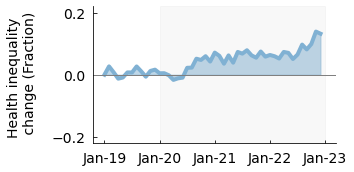

In [61]:
print(case,'====current case====')
case='age'
case='race_ethnicity'
case='income'
case='education'
#case='travel_time'

ouput_gini=pd.read_csv('results/'+case+'/all_state_gini.csv')
ouput_gini=ouput_gini[ouput_gini['year']>=2019]

for specialty in specialities:
    
    ouput_gini_temp=ouput_gini[ouput_gini['specialty']==specialty]
    ouput_relative_gini=[]
    
    for state, df_temp in ouput_gini_temp.groupby(['state']):

        norm=df_temp[df_temp['month']<=13]['gini'].mean()###in case norm=0
        
        df_temp['norm']=[norm]*len(df_temp)
        df_temp['gini']=(df_temp['gini']-(norm))/norm
        
        df_temp['gini']=moving_average(df_temp['gini'],6)
          
        if norm>=0.01:
            ouput_relative_gini.append(df_temp)
        
        if specialty=='All' and each_state_vis==True:
            temporal_curve_plot(df_temp,state,'gini','results/'+case+'/state/temporal_gini_'+state+'.png')

        
    ouput_relative_gini=pd.concat(ouput_relative_gini)
    
    
    temporal_curve_plot(ouput_relative_gini,state,'gini','results/'+case+'/temporal_gini_'+specialty+'.png')

## Section 3. Temporal inequality across specialities

In [62]:
import forestplot as fp
import scipy.stats as st
import scipy

def mean_confidence_interval(data,confidence=0.90):
    a=1.0*np.array(data)
    n=len(a)
    std=np.sqrt(data.std())
    m,se=np.mean(a),scipy.stats.sem(a)
    h=se*scipy.stats.t.ppf((1+confidence)/2.,n-1)
    return m,m-h,m+h,std




In [20]:
import scipy.stats as st
import scipy
case='age'
#case='race_ethnicity'
#case='income'
#case='education'
#case='travel_time'

def to_pandemic_period(month):
    if month<=12:
        return "pre-pandemic"
    if month>12:
        return "during-pandmeic"

specialities=['All','Emergency Medicine', 'Anesthesiology',
       'Cardiology']

ouput_gini=pd.read_csv('results/'+case+'/all_state_gini.csv')

ouput_gini=ouput_gini.dropna()
ouput_gini=ouput_gini.groupby(['month','specialty','state'])['gini'].mean().reset_index()
ouput_gini['pandemic']=list(map(lambda x: to_pandemic_period(x), ouput_gini['month']))

output_mat=[]
for specialty in specialities:
    
    ouput_gini_temp=ouput_gini[ouput_gini['specialty']==specialty] 
    
    for pandemic in ['pre-pandemic','during-pandmeic']:
        df_temp=ouput_gini_temp[ouput_gini_temp['pandemic']==pandemic]

        (mean,ll,hl,std)=mean_confidence_interval(df_temp['gini'],confidence=0.95)
        n=len(df_temp)

        output_mat.append([specialty,pandemic,n,[round(ll,4),round(hl,4)],round(mean,4),std,round(ll,4),round(hl,4)])

df_forest=pd.DataFrame(np.mat(output_mat),columns=['group','label','n','CI95%','r','std','ll','hl'])


NameError: name 'mean_confidence_interval' is not defined

In [ ]:
df_forest

In [23]:
def forest_plot(df,path_fig):
    xlabel='Gini coefficient'
        
    
    plt.figure(figsize=(5,4))
    fp.forestplot(df,  # the dataframe with results data
              estimate="r",  # col containing estimated effect size 
              ll="ll", hl="hl",  # lower & higher limits of conf. int.
              varlabel="label",  # column containing the varlabels to be printed on far left
              capitalize="capitalize",  # Capitalize labels
              groupvar='group',
              #pval="p-val",  # column containing p-values to be formatted
              annote=["n", "est_ci"],  # columns to report on left of plot
              annoteheaders=["N",  "Est. (95% Conf. Int.)"],  # ^corresponding headers
              #rightannote=["formatted_pval", "group"],  # columns to report on right of plot 
              #right_annoteheaders=["P-value", "Variable group"],  # ^corresponding headers
              color_alt_rows=True, 
              xlabel="Gini coefficient "+r"$(\times 100)$",  # x-label title
              table=True,  # Format as a table
              figsize=(8,4))
    plt.tight_layout()
    plt.savefig(path_fig,dpi=600)
    return 0


forest_plot(df_forest,'Results/'+case+'/forest_plot_'+case+'.png')


NameError: name 'df_forest' is not defined

# Significant Test on Difference

In [66]:
import scipy.stats as stats

case='age'
case='race_ethnicity'
#case='income'
#case='education'
#case='travel_time'

def to_pandemic_period(month):
    if month<=12:
        return "pre-pandemic"
    if month>12:
        return "during-pandmeic"

specialities=['All','Emergency Medicine', 'Anesthesiology',
       'Cardiology']

ouput_gini=pd.read_csv('results/'+case+'/all_state_gini.csv')
ouput_gini=ouput_gini[ouput_gini['year']>=2019]

ouput_gini['pandemic']=list(map(lambda x: to_pandemic_period(x), ouput_gini['month']))
ouput_gini=ouput_gini.dropna()

for speciality, df_temp in ouput_gini.groupby(['specialty']):
    df1=df_temp[df_temp['pandemic']=='pre-pandemic']
    df2=df_temp[df_temp['pandemic']=='during-pandmeic']
    
    (mean1,ll1,hl1,std1)=mean_confidence_interval(df1['gini'],confidence=0.95)
    (mean2,ll2,hl2,std2)=mean_confidence_interval(df2['gini'],confidence=0.95)
    t_stat, p_value = stats.ttest_ind(df1['gini'], df2['gini'],alternative='less')
    print(case, speciality,'pre-pandemic',round(mean1,3),round(ll1,3),round(hl1,3))
    print(case, speciality,'during-pandmeic',round(mean2,3),round(ll2,3),round(hl2,3))
    print(case, speciality,'difference',round(mean2-mean1,3),round(p_value,3), round((mean2-mean1)/mean1*100,1))



race_ethnicity All pre-pandemic 0.15 0.141 0.158
race_ethnicity All during-pandmeic 0.153 0.148 0.158
race_ethnicity All difference 0.003 0.25 2.3
race_ethnicity Anesthesiology pre-pandemic 0.19 0.177 0.204
race_ethnicity Anesthesiology during-pandmeic 0.182 0.174 0.19
race_ethnicity Anesthesiology difference -0.008 0.852 -4.4
race_ethnicity Cardiology pre-pandemic 0.182 0.168 0.196
race_ethnicity Cardiology during-pandmeic 0.167 0.16 0.175
race_ethnicity Cardiology difference -0.015 0.974 -8.2
race_ethnicity Emergency Medicine pre-pandemic 0.182 0.169 0.196
race_ethnicity Emergency Medicine during-pandmeic 0.176 0.167 0.184
race_ethnicity Emergency Medicine difference -0.007 0.785 -3.6


In [57]:
ouput_gini

,Unnamed: 0,gini,month,year,state,specialty,pandemic
0,0,0.016398,1,2019,AL,All,during-pandmeic
1,1,0.014963,10,2019,AL,All,during-pandmeic
2,2,0.014198,11,2019,AL,All,during-pandmeic
3,3,0.011866,12,2019,AL,All,during-pandmeic
4,4,0.009132,2,2019,AL,All,during-pandmeic
...,...,...,...,...,...,...,...
8055,7,0.118871,44,2022,WY,Cardiology,during-pandmeic
8056,8,0.074543,45,2022,WY,Cardiology,during-pandmeic
8057,9,0.118871,46,2022,WY,Cardiology,during-pandmeic
8058,10,0.081158,47,2022,WY,Cardiology,during-pandmeic
